In [78]:
import numpy as np
import pandas as pd
import os
import seaborn as sns

from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, normalize, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, precision_score,f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.metrics import sensitivity_score

import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [79]:
sns.set_style('darkgrid')

In [80]:
#Read and Print diabes.csv out screen
df = pd.read_csv("diabetes.csv")
df.head(10).style. \
                    set_properties(**{"min-width": "60px"}). \
                    set_properties(**{"color": "#111111"}). \
                    set_properties(**{"text-align": "center"}). \
                    set_table_styles([
                          {"selector": "th",
                           "props": [("font-weight", "bold"),
                                     ("font-size", "12px"),
                                     ("text-align", "center")]},
                          {"selector": "tr:nth-child(even)",
                           "props": [("background-color", "#f2f2f2")]},
                          {"selector": "tr:nth-child(odd)",
                           "props": [("background-color", "#fdfdfd")]},
                          {"selector": "tr:hover",
                           "props": [("background-color", "#bcbcbc")]}])

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600000,0.627000,50,1
1,1,85,66,29,0,26.600000,0.351000,31,0
2,8,183,64,0,0,23.300000,0.672000,32,1
3,1,89,66,23,94,28.100000,0.167000,21,0
4,0,137,40,35,168,43.100000,2.288000,33,1
5,5,116,74,0,0,25.600000,0.201000,30,0
6,3,78,50,32,88,31.000000,0.248000,26,1
7,10,115,0,0,0,35.300000,0.134000,29,0
8,2,197,70,45,543,30.500000,0.158000,53,1
9,8,125,96,0,0,0.000000,0.232000,54,1


In [81]:
#Drop Columns
pd.options.mode.chained_assignment = None

x = df.loc[:,df.columns != "Outcome"]
y = df[["Outcome"]]
#Print missing data
print("Print the missing value contains \n",df.isnull().sum())
#Print Data_info
print("x_data info: \n")
x.info()
print("\ny_data info: \n")
y.info()

Print the missing value contains 
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64
x_data info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
dtypes: float

In [82]:
y["Outcome"].value_counts() #Count 2 form

0    500
1    268
Name: Outcome, dtype: int64

In [83]:
#Split the test
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0,stratify=y)
x_train.reset_index(drop=True,inplace=True)
x_test.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

In [84]:
def plots(feature):
    fig = plt.figure(constrained_layout=True, figsize=(10, 3))
    gs = gridspec.GridSpec(nrows=1, ncols=4, figure=fig)
    ax1 = fig.add_subplot(gs[0, :3])

    # Plot histograms
    sns.histplot(data=x_train.loc[y_train["Outcome"] == 0, feature],
                 kde=False, color="#004a4d", bins=40, stat="count",
                 label="Not Diabetes", ax=ax1)
    sns.histplot(data=x_train.loc[y_train["Outcome"] == 1, feature],
                 kde=False, color="#7d0101", bins=40, stat="count",
                 label="Diabetes", ax=ax1)

    ax2 = fig.add_subplot(gs[0, 3])

    # Plot boxplot
    sns.boxplot(data=x_train, x=feature, orient="v", color="#989100", width=0.2, ax=ax2)

    ax1.legend(loc="upper right")

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1599: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


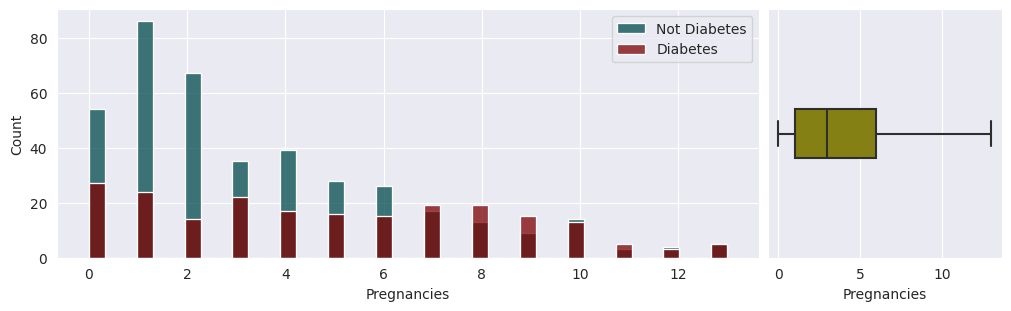

In [85]:
Q1 = x_train["Pregnancies"].quantile(0.25)
Q3 = x_train["Pregnancies"].quantile(0.75)
q95th = x_train["Pregnancies"].quantile(0.95)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

x_train["Pregnancies"] = np.where(x_train["Pregnancies"] > UW,
                                  q95th, x_train["Pregnancies"])
plots("Pregnancies")

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1599: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


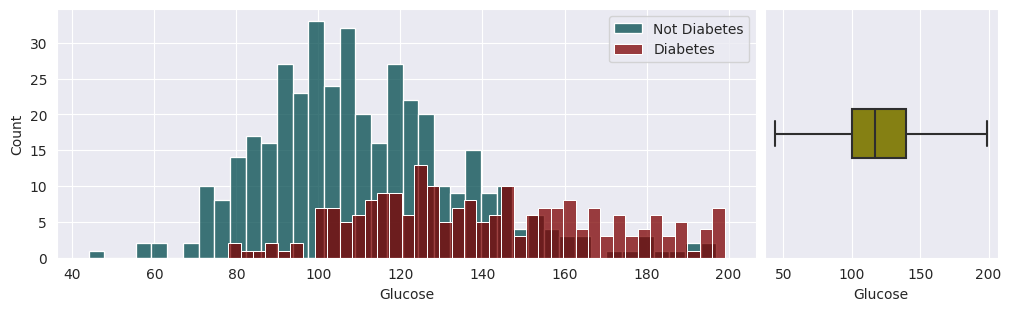

In [86]:
#Replace 0 values with median
med = x_train["Glucose"].median()
x_train["Glucose"] = np.where(x_train["Glucose"] == 0, med, x_train["Glucose"])
plots("Glucose")

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1599: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


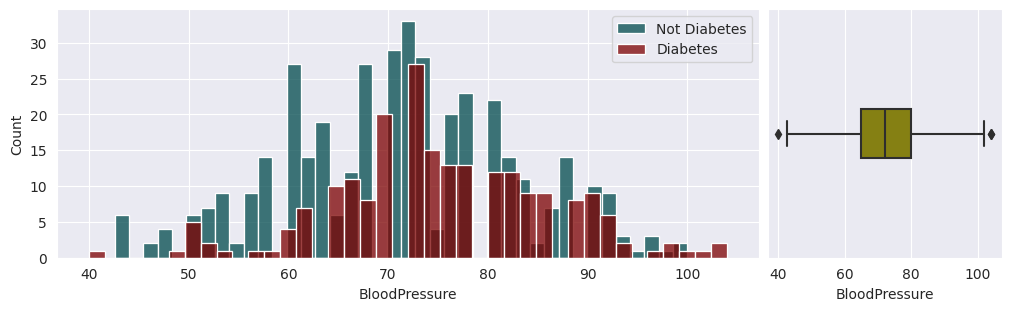

In [87]:
med = x_train["BloodPressure"].median()
q5th = x_train["BloodPressure"].quantile(0.05)
q95th = x_train["BloodPressure"].quantile(0.95)
Q1 = x_train["BloodPressure"].quantile(0.25)
Q3 = x_train["BloodPressure"].quantile(0.75)
IQR = Q3 - Q1
LW = Q1 - 1.5*IQR
UW = Q3 + 1.5*IQR
#Remove some 0 values for BloodPressure -> Replace with median
x_train["BloodPressure"] = np.where(x_train["BloodPressure"] == 0,
                                    med, x_train["BloodPressure"])
x_train["BloodPressure"] = np.where(x_train["BloodPressure"] < LW,
                                    q5th, x_train["BloodPressure"])
x_train["BloodPressure"] = np.where(x_train["BloodPressure"] > UW,
                                    q95th, x_train["BloodPressure"])
plots("BloodPressure")

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1599: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


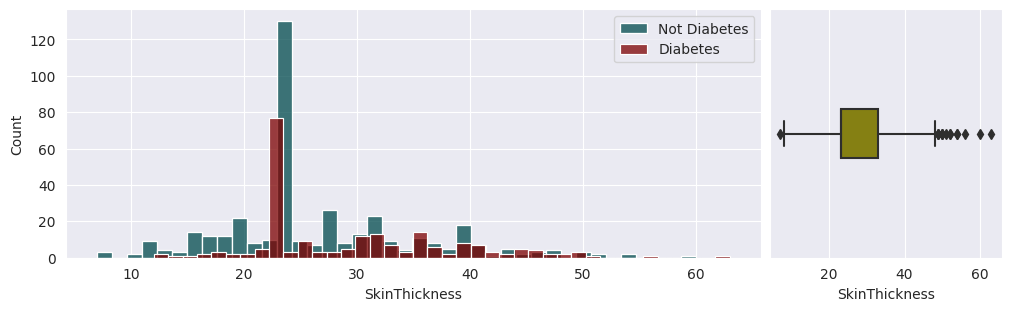

In [88]:
med = x_train["SkinThickness"].median()
q95th = x_train["SkinThickness"].quantile(0.95)
Q1 = x_train["SkinThickness"].quantile(0.25)
Q3 = x_train["SkinThickness"].quantile(0.75)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR
#Replace 0 values
x_train["SkinThickness"] = np.where(x_train["SkinThickness"] == 0,
                                    med, x_train["SkinThickness"])
x_train["SkinThickness"] = np.where(x_train["SkinThickness"] > UW,
                                    q95th, x_train["SkinThickness"])

plots("SkinThickness")

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1599: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


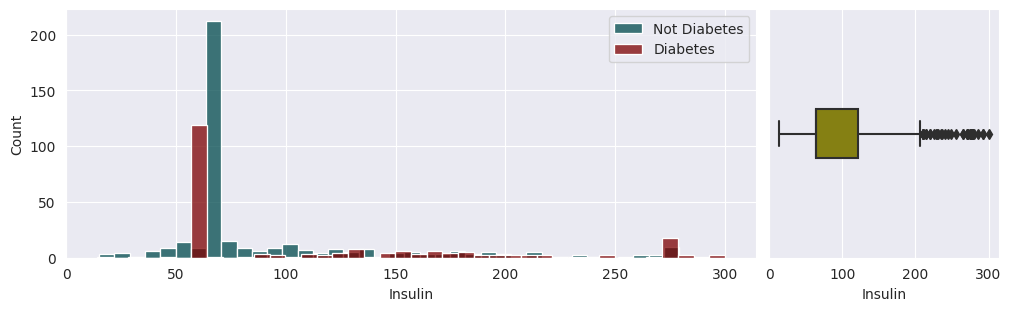

In [89]:
q60th = x_train["Insulin"].quantile(0.60)
q95th = x_train["Insulin"].quantile(0.95)
Q1 = x_train["Insulin"].quantile(0.25)
Q3 = x_train["Insulin"].quantile(0.75)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR
#Remove 0 values
x_train["Insulin"] = np.where(x_train["Insulin"] == 0,
                              q60th, x_train["Insulin"])
x_train["Insulin"] = np.where(x_train["Insulin"] > UW,
                              q95th, x_train["Insulin"])
plots("Insulin")

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1599: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


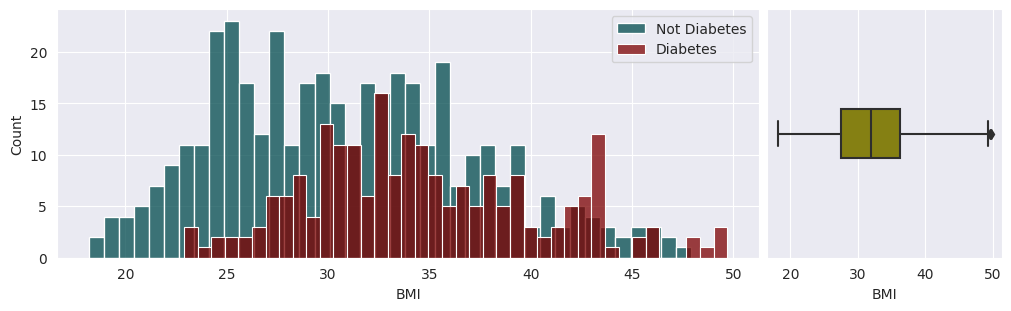

In [90]:
med = x_train["BMI"].median()
q95th = x_train["BMI"].quantile(0.95)
Q1 = x_train["BMI"].quantile(0.25)
Q3 = x_train["BMI"].quantile(0.75)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

x_train["BMI"] = np.where(x_train["BMI"] == 0,
                          med, x_train["BMI"])
x_train["BMI"] = np.where(x_train["BMI"] > UW,
                          q95th, x_train["BMI"])
plots("BMI")

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1599: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


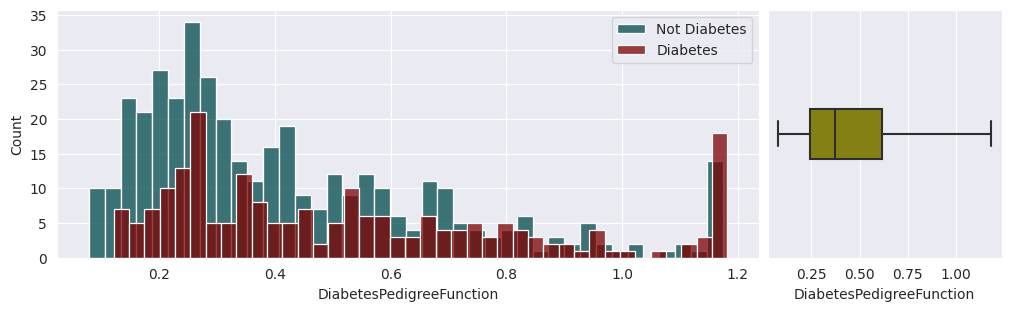

In [91]:
q95th = x_train["DiabetesPedigreeFunction"].quantile(0.95)
Q1 = x_train["DiabetesPedigreeFunction"].quantile(0.25)
Q3 = x_train["DiabetesPedigreeFunction"].quantile(0.75)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR
#Replace values greater than UW with 95th quantile
x_train["DiabetesPedigreeFunction"] = np.where(
                        x_train["DiabetesPedigreeFunction"] > UW,
                        q95th, x_train["DiabetesPedigreeFunction"])
plots("DiabetesPedigreeFunction")

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1599: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


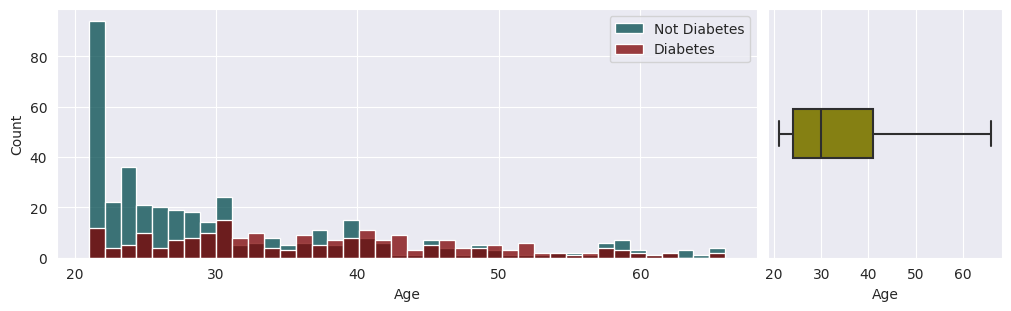

In [92]:
q95th = x_train["Age"].quantile(0.95)
Q1 = x_train["Age"].quantile(0.25)
Q3 = x_train["Age"].quantile(0.75)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

x_train["Age"] = np.where(x_train["Age"] > UW,
                          q95th, x_train["Age"])
plots("Age")

In [93]:
#Standarization
scaler_ti = StandardScaler()
x_train[['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']] = scaler_ti.fit_transform(x_train[['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']])
x_test[['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']] = scaler_ti.fit_transform(x_test[['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']])

In [94]:
#Single Perceptron
ppn_clf = Perceptron(eta0=0.001,max_iter=5000,random_state=1)
ppn_clf.fit(x_train,y_train.values.ravel())

Perceptron(eta0=0.001, max_iter=5000, random_state=1)

In [95]:
y_pred = ppn_clf.predict(x_test)
report = classification_report(y_test,y_pred, digits=4, target_names=["Not Diabetes", "Diabetes"])

In [96]:
#Print report and accuracy of Single Perceptron
ppn_acc = accuracy_score(y_test,y_pred)
ppn_precision = precision_score(y_test,y_pred)
ppn_sensitivity = sensitivity_score(y_test, y_pred, average='weighted')
ppn_f1 = f1_score(y_test,y_pred)
print("Report",report)
print("Accuracy: ", np.round(ppn_acc,2))
print("Precision: ", np.round(ppn_precision,2))
print("Sensitivity: ", np.round(ppn_sensitivity,2))
print("F1_Score: ", np.round(ppn_f1,2))

Report               precision    recall  f1-score   support

Not Diabetes     0.8434    0.7000    0.7650       100
    Diabetes     0.5775    0.7593    0.6560        54

    accuracy                         0.7208       154
   macro avg     0.7104    0.7296    0.7105       154
weighted avg     0.7501    0.7208    0.7268       154

Accuracy:  0.72
Precision:  0.58
Sensitivity:  0.72
F1_Score:  0.66


In [97]:
#Gausiaan Classifier
g_clf = GaussianNB()
g_clf.fit(x_train, y_train.values.ravel())
y_pred = g_clf.predict(x_test)

In [98]:
report = classification_report(y_test,y_pred, digits=4, target_names=["Not Diabetes", "Diabetes"])

In [99]:
#Print report and accuracy of Gaussian Classifier
g_acc = accuracy_score(y_test,y_pred)
g_precision = precision_score(y_test,y_pred)
g_sensitivity = sensitivity_score(y_test, y_pred, average='weighted')
g_f1 = f1_score(y_test,y_pred)
print("Report",report)
print("Accuracy: ", np.round(g_acc,2))
print("Precision: ", np.round(g_precision,2))
print("Sensitivity: ", np.round(g_sensitivity,2))
print("F1_score: ", np.round(g_f1,2))

Report               precision    recall  f1-score   support

Not Diabetes     0.7961    0.8200    0.8079       100
    Diabetes     0.6471    0.6111    0.6286        54

    accuracy                         0.7468       154
   macro avg     0.7216    0.7156    0.7182       154
weighted avg     0.7438    0.7468    0.7450       154

Accuracy:  0.75
Precision:  0.65
Sensitivity:  0.75
F1_score:  0.63


In [100]:
#K-NN
test_scores = []
train_scores = []
for i in range(1, 15):
  knn = KNeighborsClassifier(i)
  knn.fit(x_train, y_train.values.ravel())
  train_scores.append(knn.score(x_train,y_train.values.ravel()))
  test_scores.append(knn.score(x_test,y_test))

In [101]:
#Max Score testing on datapoint
def max_score(scores):
  max_score = max(scores)
  scores_indx = [i for i, v in enumerate(scores) if v == max_score]
  return print('Max test score {} % and k = {}'.format(max_score*100,list(map(lambda x: x+1, scores_indx))))

In [102]:
#K-NN scores that comes from testing on the same datapoints were used for training
max_score(train_scores)
max_score(test_scores)

Max test score 100.0 % and k = [1]
Max test score 79.87012987012987 % and k = [5, 7, 13]


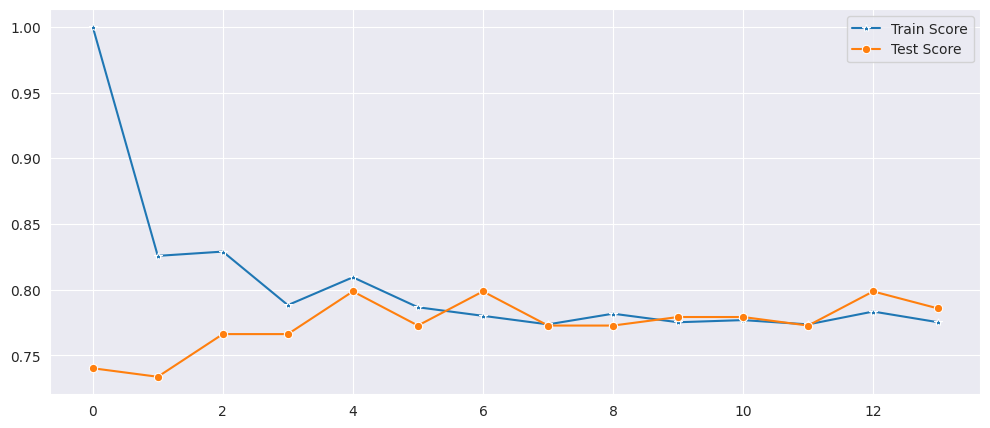

In [103]:
plt.figure(figsize=(12,5))
p = sns.lineplot(train_scores,marker='*',label='Train Score')
p = sns.lineplot(test_scores,marker='o',label='Test Score')

In [104]:
#The best result is captured at k = 4 -> We used k=4 for the final
knn=KNeighborsClassifier(4)
knn.fit(x_train,y_train.values.ravel())
knn.score(x_test,y_test)
y_pred = knn.predict(x_test)

In [105]:
report = classification_report(y_test,y_pred, digits=4, target_names=["Not Diabetes", "Diabetes"])
knn_acc = accuracy_score(y_test,y_pred)
knn_precision = precision_score(y_test,y_pred)
knn_sensitivity = sensitivity_score(y_test, y_pred, average='weighted')
knn_f1 = f1_score(y_test,y_pred)
print("Report",report)
print("Accuracy: ", np.round(knn_acc,2))
print("Precision: ", np.round(knn_precision,2))
print("Sensitivity: ", np.round(knn_sensitivity,2))
print("F1_Score: ", np.round(knn_f1, 2))

Report               precision    recall  f1-score   support

Not Diabetes     0.7540    0.9500    0.8407       100
    Diabetes     0.8214    0.4259    0.5610        54

    accuracy                         0.7662       154
   macro avg     0.7877    0.6880    0.7008       154
weighted avg     0.7776    0.7662    0.7426       154

Accuracy:  0.77
Precision:  0.82
Sensitivity:  0.77
F1_Score:  0.56


In [106]:
x_train.drop("SkinThickness",axis=1,inplace=True)
x_test.drop("SkinThickness",axis=1,inplace=True)

In [107]:
#Multiple Layer Perceptron (MLP)
mlp_clf = MLPClassifier(solver="adam", max_iter=5000, activation="relu",
                        hidden_layer_sizes= (12),
                        alpha = 0.01,
                        batch_size = 64,
                        learning_rate_init = 0.001,
                        random_state=2)
mlp_clf.fit(x_train,y_train.values.ravel())

MLPClassifier(alpha=0.01, batch_size=64, hidden_layer_sizes=12, max_iter=5000,
              random_state=2)

In [108]:
y_pred = mlp_clf.predict(x_test)
report = classification_report(y_test,y_pred, digits=4, target_names=["Not Diabetes", "Diabetes"])

In [109]:
#Print report and accuracy of Multiple Layer Perceptron
mlp_acc = accuracy_score(y_test,y_pred)
mlp_precision = precision_score(y_test,y_pred)
mlp_sensitivity = sensitivity_score(y_test, y_pred, average='weighted')
mlp_f1 = f1_score(y_test,y_pred)
print("Report",report)
print("Accuracy: ", np.round(mlp_acc,2))
print("Precision: ", np.round(mlp_precision,2))
print("Sensitivity: ", np.round(mlp_sensitivity,2))
print("F1_Score: ", np.round(mlp_f1, 2))

Report               precision    recall  f1-score   support

Not Diabetes     0.8762    0.9200    0.8976       100
    Diabetes     0.8367    0.7593    0.7961        54

    accuracy                         0.8636       154
   macro avg     0.8565    0.8396    0.8468       154
weighted avg     0.8624    0.8636    0.8620       154

Accuracy:  0.86
Precision:  0.84
Sensitivity:  0.86
F1_Score:  0.8


In [114]:
all_performance_metrics = pd.DataFrame([
    [ppn_acc, ppn_precision, ppn_sensitivity, ppn_f1],
    [g_acc, g_precision, g_sensitivity, g_f1],
    [knn_acc, knn_precision, knn_sensitivity, knn_f1],
    [mlp_acc, mlp_precision, mlp_sensitivity, mlp_f1],
], index= ['PPN', 'GB', 'k-NN', 'MLP'],
columns = ['Accuracy', 'Precision', 'Sensitivity', 'F1_Score'])
all_performance_metrics

,Accuracy,Precision,Sensitivity,F1_Score
PPN,0.720779,0.577465,0.720779,0.656000
GB,0.746753,0.647059,0.746753,0.628571
k-NN,0.766234,0.821429,0.766234,0.560976
MLP,0.863636,0.836735,0.863636,0.796117


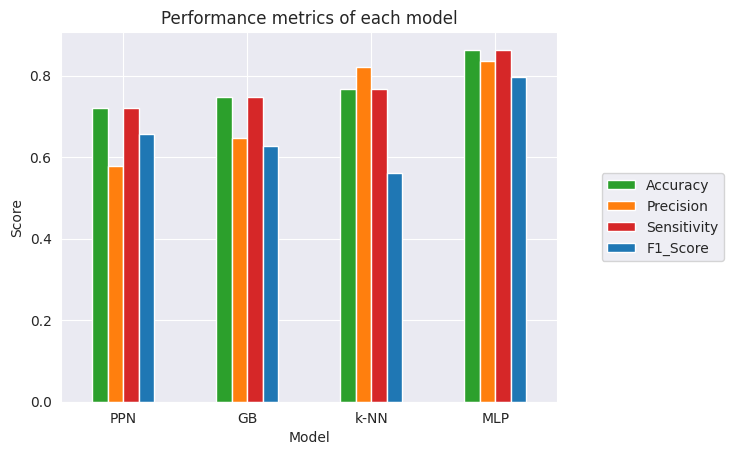

In [115]:
all_performance_metrics['Model'] = all_performance_metrics.index.values
colors = ['tab:green', 'tab:orange', 'tab:red', 'tab:blue']
all_performance_metrics.plot(x = 'Model', kind = 'bar', rot = 0, color = colors)
plt.title('Performance metrics of each model')
plt.xlabel('Model')
plt.ylabel('Score')
plt.legend(loc='center right', bbox_to_anchor=(1.35, 0.5))
plt.show()